# MoE


In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import itertools
import os 
import sys


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from moe_model import MoE as MoE_raw, MLP as MoE_Expert


class MoE_Expert_Logits(MoE_Expert):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__(input_size, output_size, hidden_size)
        # Replace the final softmax layer with an identity layer
        self.soft = nn.Identity()


In [175]:
def train_and_evaluate_trial(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoE model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    model = MoE_raw(
        input_size=X_train.shape[1],
        output_size=2,
        num_experts=params['num_experts'],
        hidden_size=params['hidden_size'],
        k=params['k']
    )
    model.experts = nn.ModuleList([
        MoE_Expert_Logits(
            input_size=X_train.shape[1],
            output_size=2,
            hidden_size=params['hidden_size']
        ) for _ in range(model.num_experts)
    ])
    model.to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred, aux_loss = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor) + aux_loss
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, val_aux_loss = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor) + val_aux_loss
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _ = model(X_val_tensor)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        # Get detailed metrics from classification report for class '1'
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'num_experts': params['num_experts'],
            'hidden_size': params['hidden_size'],
            'k': params['k'],
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


In [176]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'uk_biobank_dataset.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False)
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_data.csv' not found. Please run the feature extractor first.")

# --- 2. Define the Hyperparameter Grid ---
param_grid = {
    'num_experts': [3, 4, 6, 8],
    'hidden_size': [16, 32, 64],
    'k': [2, 3, 4]
}

# Create all possible combinations
all_params = list(itertools.product(
    param_grid['num_experts'],
    param_grid['hidden_size'],
    param_grid['k']
))

# Filter out invalid combinations where k > num_experts
valid_params = [
    {'num_experts': p[0], 'hidden_size': p[1], 'k': p[2]}
    for p in all_params if p[2] <= p[0]
]

print(f"\n🔹 Starting Grid Search. Total combinations to test: {len(valid_params)}")


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (926, 64)

🔹 Starting Grid Search. Total combinations to test: 33


In [177]:

# --- 3. Run the Grid Search ---
results = []
for i, params in enumerate(valid_params):
    print(f"\n--- Testing Combination {i+1}/{len(valid_params)} ---")
    print(f"Parameters: {params}")
    
    result = train_and_evaluate_trial(params, X_train_scaled, y_train.values, X_val_scaled, y_val.values)
    results.append(result)
    
    # Live update of results
    clear_output(wait=True)
    results_df = pd.DataFrame(results).sort_values('val_f1_score', ascending=False)
    print("✅ Intermediate Tuning Results (Validation Set):")
    display(results_df)

# --- 4. Final Evaluation on Test Set ---
print("\n\n" + "="*40 + "\n✅ FINAL EVALUATION ON HELD-OUT TEST SET\n" + "="*40)

# Get the best parameters from the grid search
best_params = results_df.iloc[0].to_dict()
print("🏆 Best Hyperparameters found (based on validation F1-score):")
print(f"  - Number of Experts: {int(best_params['num_experts'])}")
print(f"  - Hidden Size: {int(best_params['hidden_size'])}")
print(f"  - Top K: {int(best_params['k'])}")

# Combine training and validation data
X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

print("\nRetraining the best model on combined Train+Validation data...")

# Create the final model with the best parameters
final_model = MoE_raw(
    input_size=X_train_val.shape[1],
    output_size=2,
    num_experts=int(best_params['num_experts']),
    hidden_size=int(best_params['hidden_size']),
    k=int(best_params['k'])
)
final_model.experts = nn.ModuleList([
    MoE_Expert_Logits(
        input_size=X_train_val.shape[1],
        output_size=2,
        hidden_size=int(best_params['hidden_size'])
    ) for _ in range(final_model.num_experts)
])

# Train the final model and evaluate on the test set
final_results = train_and_evaluate_trial(
    {'num_experts': int(best_params['num_experts']), 'hidden_size': int(best_params['hidden_size']), 'k': int(best_params['k'])},
    X_train_val, y_train_val, X_test_scaled, y_test.values
)

# --- Print all requested metrics for the final evaluation ---
print("\n--- Final Performance on Test Set ---")
print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
print(f"  - Precision:   {final_results['val_precision']:.4f}")
print(f"  - Recall:      {final_results['val_recall']:.4f}")
print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")


✅ Intermediate Tuning Results (Validation Set):


,num_experts,hidden_size,k,val_roc_auc,val_accuracy,val_f1_score,val_precision,val_recall,val_cohen_kappa
1,3,16,3,0.805005,0.745140,0.756198,0.732000,0.782051,0.489841
23,6,64,4,0.808961,0.738661,0.753564,0.719844,0.790598,0.476699
26,8,16,4,0.797606,0.730022,0.748491,0.707224,0.794872,0.459249
20,6,32,4,0.796869,0.727862,0.744939,0.707692,0.786325,0.454999
28,8,32,3,0.796850,0.727862,0.742857,0.710938,0.777778,0.455101
32,8,64,4,0.789236,0.725702,0.738144,0.713147,0.764957,0.450904
11,4,32,4,0.792129,0.723542,0.736626,0.710317,0.764957,0.446555
31,8,64,3,0.796085,0.719222,0.734694,0.703125,0.769231,0.437802
2,3,32,2,0.785037,0.710583,0.733068,0.686567,0.786325,0.420179
10,4,32,3,0.784067,0.723542,0.732218,0.717213,0.747863,0.446762




✅ FINAL EVALUATION ON HELD-OUT TEST SET
🏆 Best Hyperparameters found (based on validation F1-score):
  - Number of Experts: 3
  - Hidden Size: 16
  - Top K: 3

Retraining the best model on combined Train+Validation data...

--- Final Performance on Test Set ---
  - Accuracy:    0.7134
  - ROC-AUC:     0.7729
  - F1-Score:    0.7176
  - Precision:   0.7161
  - Recall:      0.7191
  - Cohen Kappa: 0.4266




🚀 Starting SHAP Analysis

--- Analyzing Overall MoE Model ---


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


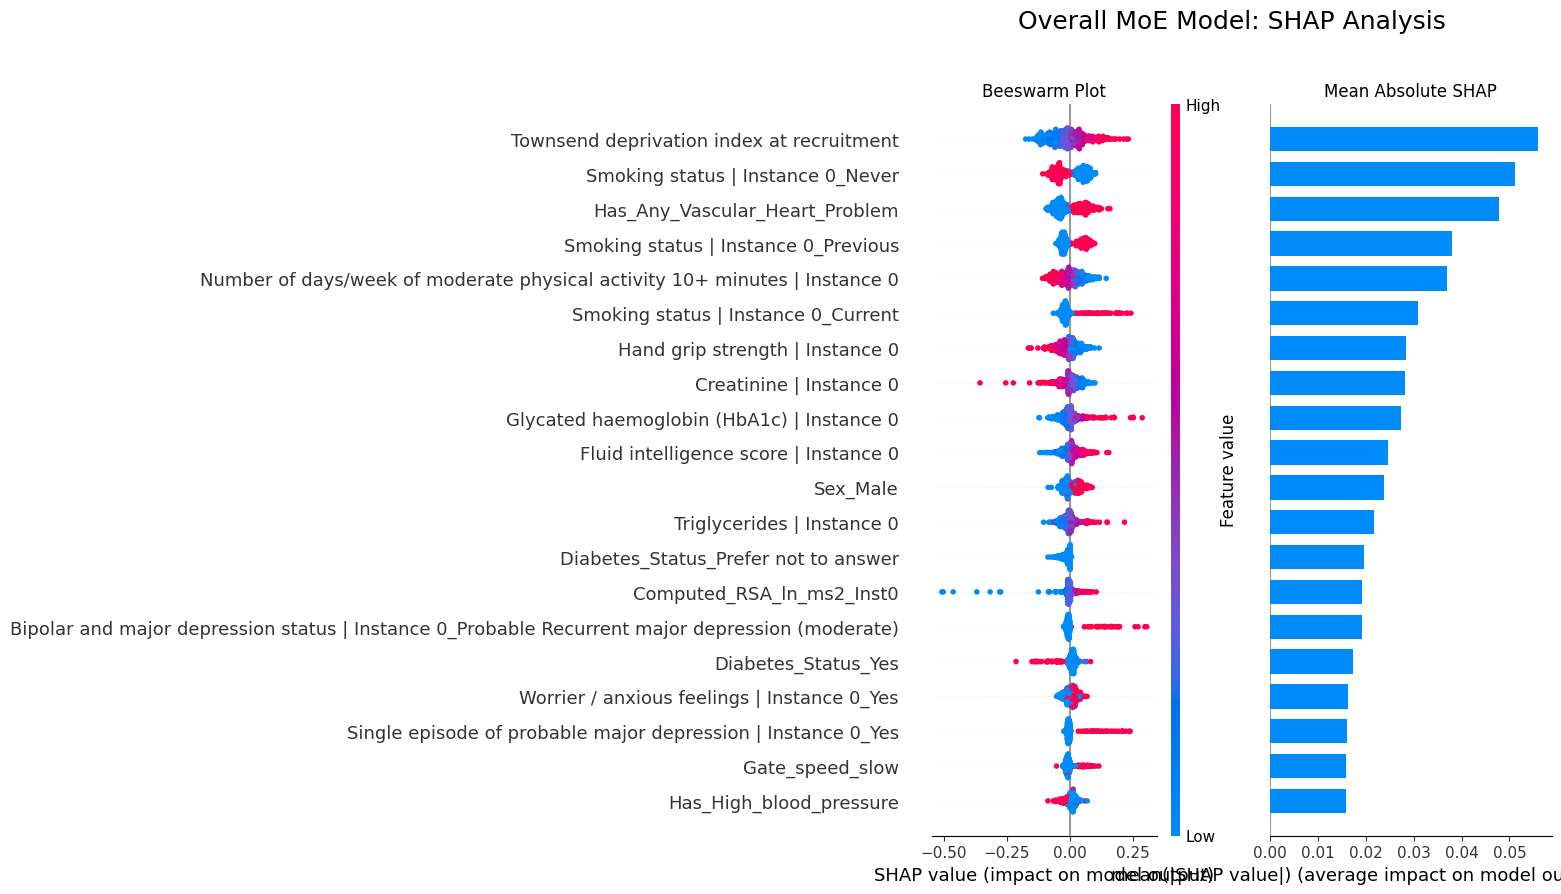



🕵️ Analyzing Expert Specializations

--- Analyzing 183 samples routed to Expert 1 ---


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


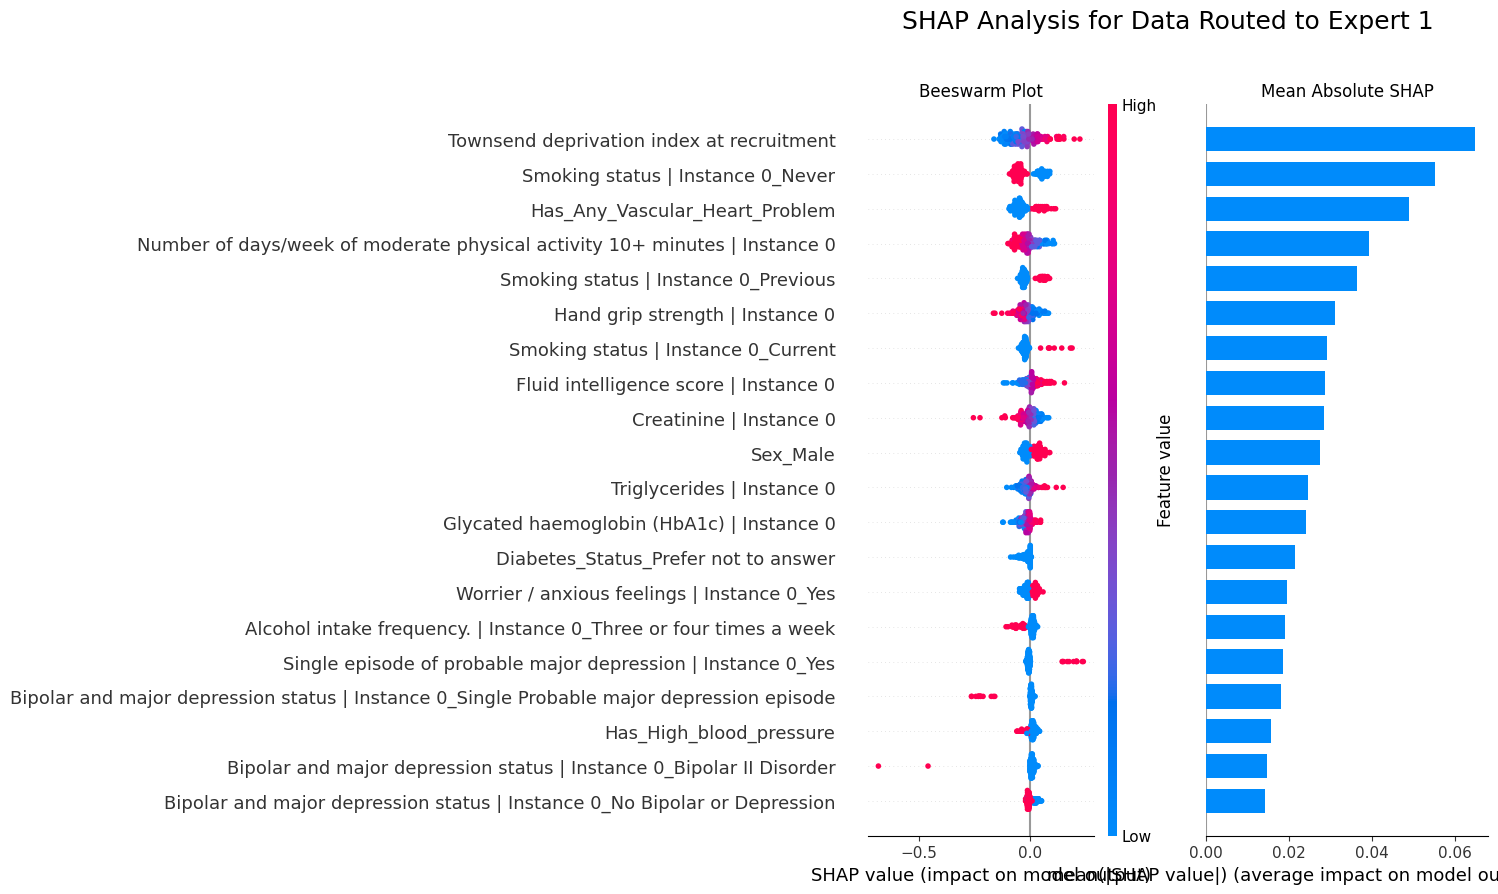


--- Analyzing 144 samples routed to Expert 2 ---


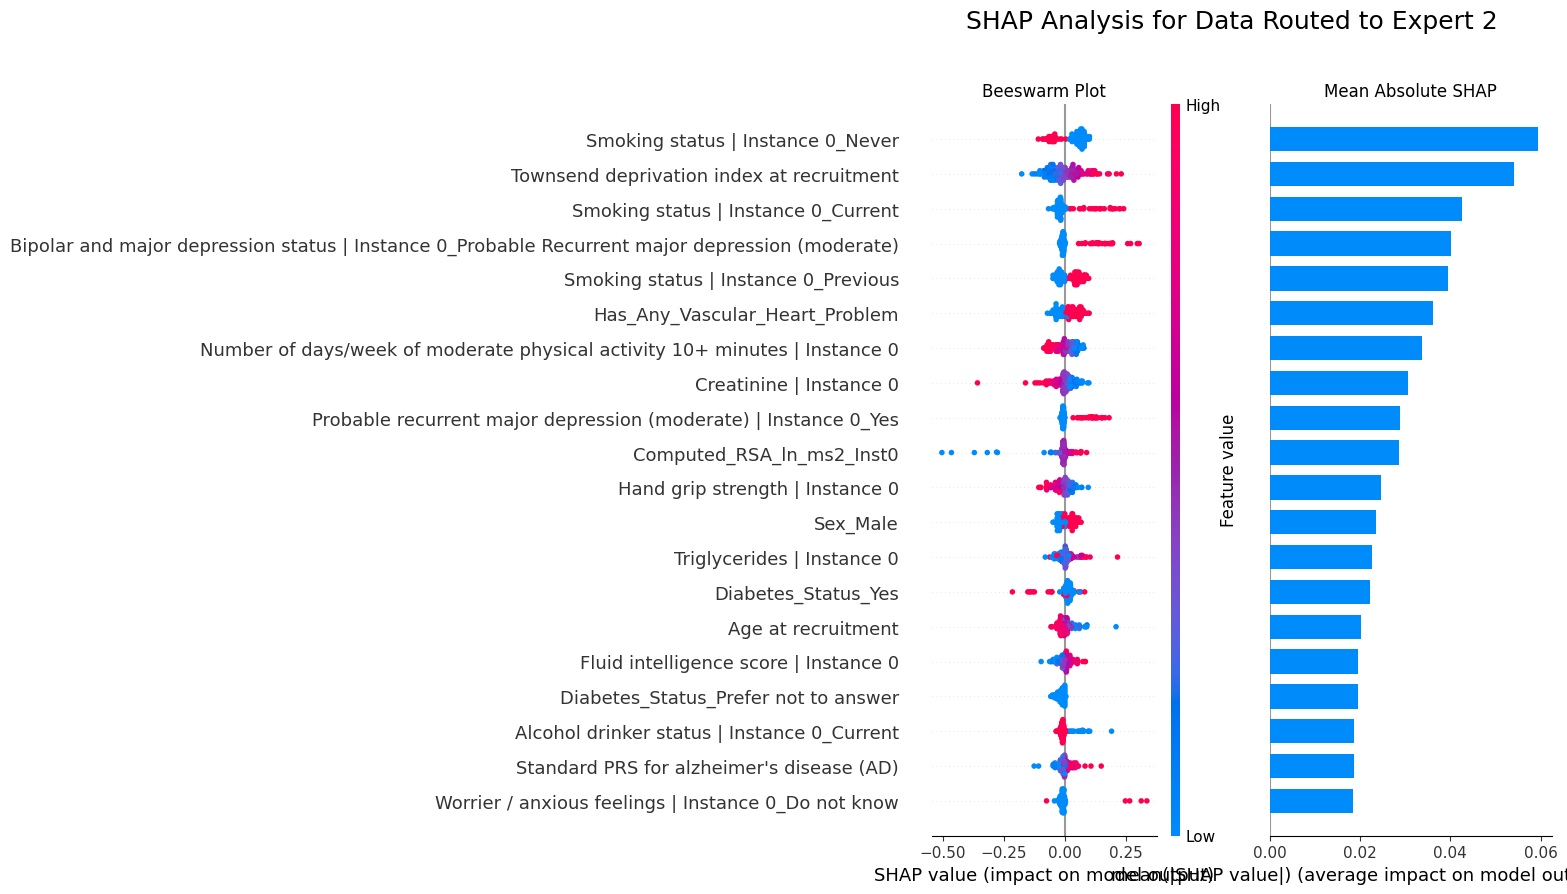


--- Analyzing 137 samples routed to Expert 3 ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


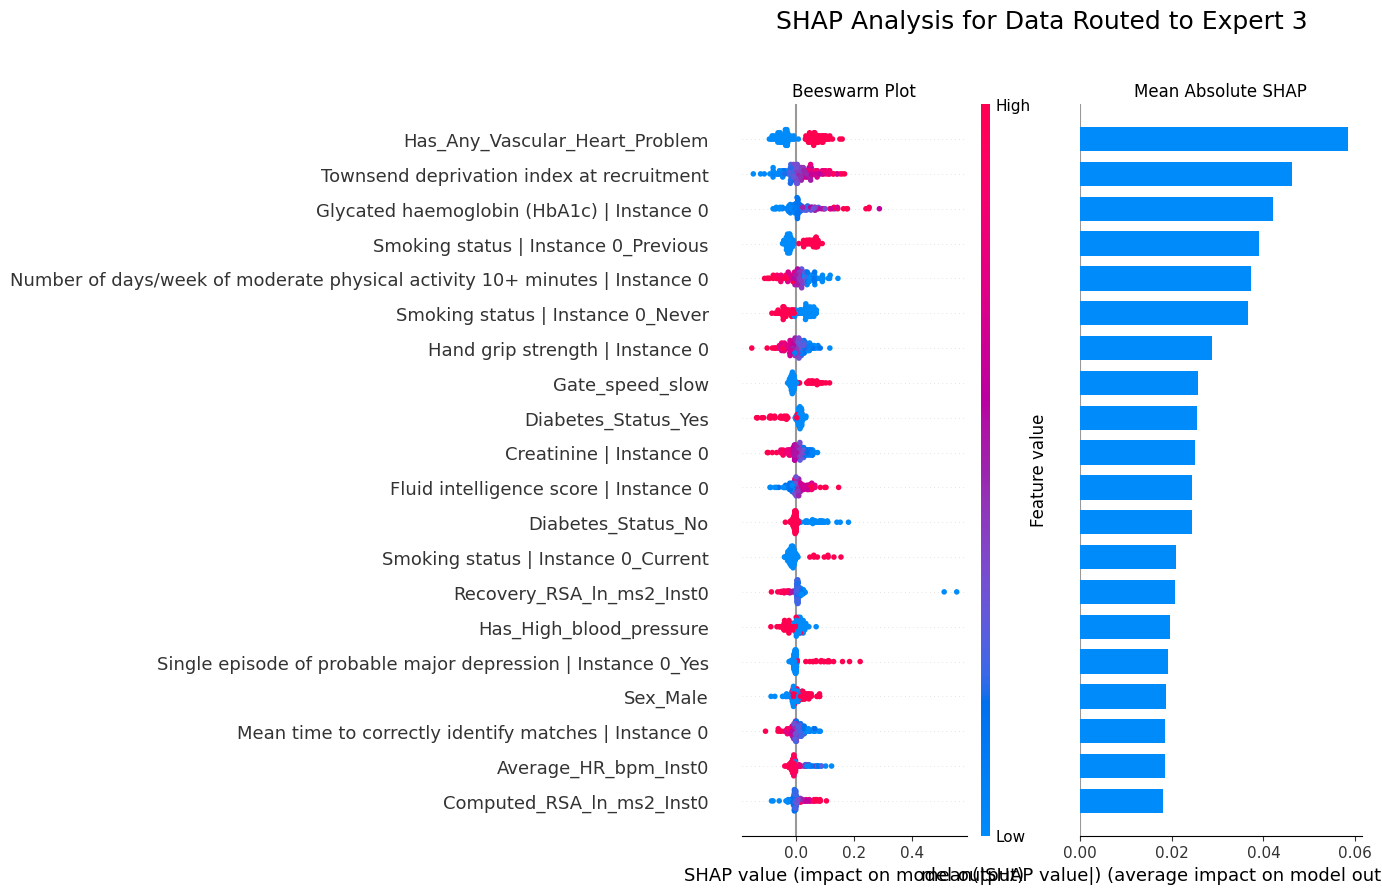

In [178]:
import shap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# ===================================================================
# SHAP Analysis of the Final, Best MoE Model
# ===================================================================
print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis\n" + "="*40)

# --- 1. Prepare data and calculate SHAP for the OVERALL model ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_model.to(device)
final_model.eval()

background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

print("\n--- Analyzing Overall MoE Model ---")
# Define a wrapper for the SHAP explainer
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        self.model.train()
        pred, _ = self.model(x)
        return pred

# Calculate SHAP values for the entire model once
shap_model_wrapper = ShapModelWrapper(final_model)
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)
shap_values = explainer.shap_values(test_tensor)

# --- 2. Plot the OVERALL model's SHAP analysis ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True) 
fig.suptitle("Overall MoE Model: SHAP Analysis", fontsize=18)

# Beeswarm Plot
plt.sca(axes[0])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
axes[0].set_title("Beeswarm Plot")

# Bar Plot
plt.sca(axes[1])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
axes[1].set_title("Mean Absolute SHAP")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ===================================================================
# SHAP Analysis for INDIVIDUAL Experts
# ===================================================================
print("\n\n" + "="*40 + "\n🕵️ Analyzing Expert Specializations\n" + "="*40)

# --- 3. Get the gating decisions for the entire test set ---
with torch.no_grad():
    gating_logits = test_tensor @ final_model.w_gate
    
    # Find the winning expert for each sample (the one with the highest logit)
    chosen_experts = torch.argmax(gating_logits, dim=1).cpu().numpy()

# --- 4. Loop through each expert and analyze the data routed to it ---
num_experts = final_model.num_experts
for i in range(num_experts):
    # Find the indices of all samples that were routed to the current expert 'i'
    samples_for_this_expert_indices = np.where(chosen_experts == i)[0]

    # Check if any samples were actually routed to this expert
    if len(samples_for_this_expert_indices) == 0:
        print(f"\n--- No samples were primarily routed to Expert {i+1}. Skipping. ---")
        continue

    print(f"\n--- Analyzing {len(samples_for_this_expert_indices)} samples routed to Expert {i+1} ---")

    # Filter the OVERALL shap_values and test_data for this expert's specific subset
    shap_subset = shap_values[1][samples_for_this_expert_indices]
    X_test_subset = X_test_scaled[samples_for_this_expert_indices]

    # --- Create the side-by-side plots for this expert's data ---
    fig_expert, axes_expert = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    fig_expert.suptitle(f"SHAP Analysis for Data Routed to Expert {i+1}", fontsize=18)
    
    # Beeswarm Plot
    plt.sca(axes_expert[0])
    shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="dot", show=False)
    axes_expert[0].set_title("Beeswarm Plot")

    # Bar Plot
    plt.sca(axes_expert[1])
    shap.summary_plot(shap_subset, features=X_test_subset, feature_names=X.columns, plot_type="bar", show=False)
    axes_expert[1].set_title("Mean Absolute SHAP")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



🚦 Analyzing MoE Expert Routing on Test Data

--- Routing Percentage Table (%) ---
This table shows the percentage of test samples routed to each expert.


,Expert 1,Expert 2,Expert 3
Gating Layer,39.44%,31.03%,29.53%




--- Routing Percentage Heatmap ---


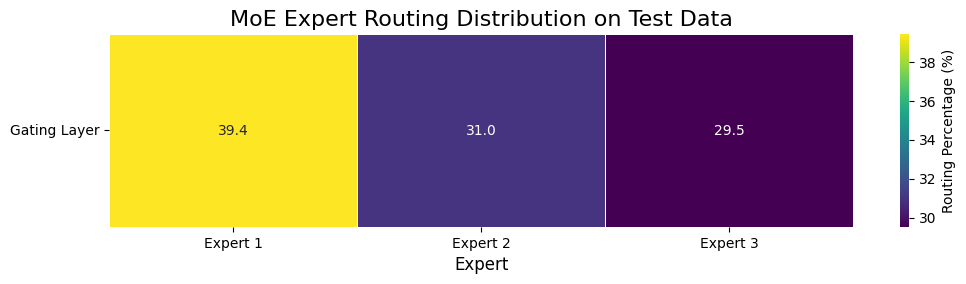

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import torch
import numpy as np

# ===================================================================
# MoE Routing Analysis
# ===================================================================
print("\n\n" + "="*40 + "\n🚦 Analyzing MoE Expert Routing on Test Data\n" + "="*40)

try:
    # --- 1. Get Gating Decisions from the Final Model ---
    final_model.eval()
    with torch.no_grad():
        # Get the gating scores (logits)
        gating_logits = test_tensor @ final_model.w_gate
        # Find the winning expert for each sample
        chosen_experts = torch.argmax(gating_logits, dim=1).cpu().numpy()

    # --- 2. Calculate Routing Percentages ---
    num_samples = test_tensor.shape[0]
    num_experts = final_model.num_experts
    
    # Count how many times each expert was chosen
    counts = np.bincount(chosen_experts, minlength=num_experts)
    
    # Convert counts to a percentage
    percentages = (counts / num_samples) * 100
    
    # --- 3. Create and Display the Routing Table ---
    expert_names = [f'Expert {j+1}' for j in range(num_experts)]
    routing_df = pd.DataFrame([percentages], index=['Gating Layer'], columns=expert_names)

    print("\n--- Routing Percentage Table (%) ---")
    print("This table shows the percentage of test samples routed to each expert.")
    display(routing_df.style.format("{:.2f}%"))

    # --- 4. Create and Display the Routing Heatmap ---
    print("\n\n--- Routing Percentage Heatmap ---")
    plt.figure(figsize=(12, 2.5)) # Adjusted figsize for a single-row heatmap
    sns.heatmap(
        routing_df, 
        annot=True,          # Show the percentage values in the cells
        fmt=".1f",           # Format values to one decimal place
        cmap="viridis",      # Use the 'viridis' color map
        linewidths=.5,       # Add thin lines between cells
        cbar_kws={'label': 'Routing Percentage (%)'} # Add a label to the color bar
    )
    plt.title("MoE Expert Routing Distribution on Test Data", fontsize=16)
    plt.xlabel("Expert", fontsize=12)
    plt.ylabel("") 
    plt.yticks(rotation=0) 
    plt.show()

except NameError:
    print("Error: `final_model` or `test_tensor` not found. ")

In [180]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

# ===================================================================
# Calculate Overall Expert Specialization
# ===================================================================
print("\n\n" + "="*40 + "\n 📊 Calculating Overall Expert Specialization \n" + "="*40)

try:
    # --- Step 1: Extract Mean Absolute SHAP Vector for Each Expert ---
    mean_abs_shap_vectors = {}
    num_experts = final_model.num_experts
    
    # This loop re-uses 'shap_values' and 'chosen_experts' from the previous SHAP analysis cell.
    for i in range(num_experts):
        # Find the indices of all samples that were routed to the current expert 'i'
        samples_for_this_expert_indices = np.where(chosen_experts == i)[0]

        # Skip experts that received no data
        if len(samples_for_this_expert_indices) == 0:
            continue

        # Filter the overall shap_values for this expert's subset
        shap_subset = shap_values[1][samples_for_this_expert_indices]
        
        # Calculate the mean absolute SHAP values for this expert and store it
        mean_vector = np.abs(shap_subset).mean(axis=0)
        mean_abs_shap_vectors[f'Expert {i+1}'] = mean_vector
        
    print(f"Extracted feature importance vectors for {len(mean_abs_shap_vectors)} active experts.")

    # --- Step 2: Compute the Specialization Index ---
    if len(mean_abs_shap_vectors) < 2:
        print("\nCannot calculate specialization with less than two active experts.")
    else:
        # Combine the vectors into a single matrix
        shap_matrix = np.array(list(mean_abs_shap_vectors.values()))
        
        # Compute the pairwise cosine similarity matrix
        similarity_matrix = cosine_similarity(shap_matrix)
        
        # Get the unique off-diagonal comparisons (from the upper triangle of the matrix)
        indices = np.triu_indices(shap_matrix.shape[0], k=1)
        off_diagonal_values = similarity_matrix[indices]
        mean_similarity = np.mean(off_diagonal_values)
        
        # Calculate the final Specialization Index
        specialization_index = 1 - mean_similarity

        print(f"\n--- Overall Specialization Analysis ---")
        print(f"Average similarity between experts: {mean_similarity:.4f}")
        print(f"Overall Specialization Index: {specialization_index:.4f}")


except NameError:
    print("Error: `shap_values` or `chosen_experts` not found. Please run the main SHAP analysis block first.")



 📊 Calculating Overall Expert Specialization 
Extracted feature importance vectors for 3 active experts.

--- Overall Specialization Analysis ---
Average similarity between experts: 0.9128
Overall Specialization Index: 0.0872
